In [1]:
from QAOAUtils import *
from oputils import *
import pickle as pkl
import numpy as np

In [2]:
DATA = []
ws_list = ['GW2','GW3','BM2','BM3']
n = 17
rotation_options = list(range(n))+[None]
samples = 5
prob_count = 100

In [3]:
def TSP_QUBO(n,max_val,eps_list):
    points = np.random.random((n,2)) * max_val * 2 - max_val
    W_mat = np.array([[np.linalg.norm(points[i]-points[j]) for i in range(n)] for j in range(n)])

    A_list = [num_to_bin((1+eps)*np.max(W_mat),(n-1)**2) for eps in eps_list]
    reward = num_to_bin(0,(n-1)**2)
    for i in range(0,n-1):
        for j in range(0,n-1):
            for t in range(0,n-2):
                reward += num_to_bin(W_mat[i+1][j+1],(n-1)**2) * indexed_bin_op((n-1)*t+i,(n-1)**2) *  indexed_bin_op((n-1)*(t+1)+j,(n-1)**2)
        reward += num_to_bin(W_mat[0][i+1],(n-1)**2) * indexed_bin_op(i,(n-1)**2) 
        reward += num_to_bin(W_mat[0][i+1],(n-1)**2) *  indexed_bin_op((n-1)*(n-2)+i,(n-1)**2)
    
    penalty1=num_to_bin(0,(n-1)**2)
    for t in range(n-1):
        temp_op = num_to_bin(1,(n-1)**2)
        for i in range(n-1):
            temp_op -= indexed_bin_op((n-1)*t+i,(n-1)**2)
        penalty1+=temp_op**2
    
    penalty2=num_to_bin(0,(n-1)**2)
    for i in range(n-1):
        temp_op = num_to_bin(1,(n-1)**2)
        for t in range(n-1):
            temp_op -= indexed_bin_op((n-1)*t+i,(n-1)**2)
        penalty2+=temp_op**2
    
    cost = [reward+A*(penalty1+penalty2) for A in A_list]

    return points,W_mat, [bin_to_qubo(c) for c in cost]

In [4]:
def MIS_QUBO(n,A_list,graph='gnp'):
    if(graph == 'gnp'):
        G=nx.gnp_random_graph(n,0.25)
        return  [np.diag(np.ones(n))- (A/2) *nx.adjacency_matrix(G).toarray() for A in A_list]
    elif(graph=='nws'):
        G=nx.newman_watts_strogatz_graph(n,3,0.5)
        return [np.diag(np.ones(n))- (A/2) *nx.adjacency_matrix(G).toarray() for A in A_list]
    elif(graph=='regular'):
        G=nx.random_regular_graph(3,n)
        return [np.diag(np.ones(n))-(A/2) *nx.adjacency_matrix(G).toarray() for A in A_list]
    else:
        return "????"

In [5]:
def depth0_ws_comp(n,A_list,ws_list = ['BM2','BM3','GW2','GW3'],rotation_options = None):
    if(rotation_options is None):
        rotation_options = list(range(n))+[None]
    best_angle_data = {ws: {'max_cost':[],'max_probs':[]}  for ws in ws_list}
    comparison_data = {ws: {-1:{'cost':[],'probs':[]},0:{'cost':[],'probs':[]},None:{'cost':[],'probs':[]}}  for ws in ws_list} | {None:{'cost':[], 'probs':[]}}
    ws_data = []
    for _ in tqdm(range(len(A_list))):

        A = A_list[_]
        initial_data = initialize(A)
        precomp = initial_data[0]
        BM2_theta_list = initial_data[1]
        BM3_theta_list = initial_data[2]
        GW2_theta_list = initial_data[3]
        GW3_theta_list = initial_data[4]
        v = initial_data[5]
        M = initial_data[6]
        ws_data.append(initial_data)
        A_list.append(A)
        qc_data = {'BM2':{r: Q2_data(BM2_theta_list,r) for r in rotation_options},
        'BM3':{r:Q3_data(BM3_theta_list,r) for r in rotation_options},
        'GW2':{r:Q2_data(GW2_theta_list,r) for r in rotation_options},
        'GW3':{r:Q3_data(GW3_theta_list,r) for r in rotation_options}}
    
        opt_data = {ws:{'cost':[],'probs':[]} for ws in ws_list}
        
        for ws in ws_list:
            for r in rotation_options:
                opt_data[ws]['cost'].append(expval(precomp,QAOA_eval(precomp,[],mixer_ops=qc_data[ws][r][1],init=qc_data[ws][r][0])))
                opt_data[ws]['probs'].append(opt_sampling_prob(v,precomp,[],mixer_ops=qc_data[ws][r][1],init=qc_data[ws][r][0]))
            l = np.argwhere(opt_data[ws]['cost']==np.max(opt_data[ws]['cost']))
            l = np.reshape(l,(len(l),))
            best_angle_data[ws]['max_cost']+=[l.tolist()]
            l = np.argwhere(opt_data[ws]['probs']==np.max(opt_data[ws]['probs']))
            l = np.reshape(l,(len(l),))
            best_angle_data[ws]['max_probs']+=[l.tolist()]

            comparison_data[ws][-1]['cost'].append(opt_data[ws]['cost'][-2])
            comparison_data[ws][-1]['probs'].append(opt_data[ws]['probs'][-2])
            comparison_data[ws][None]['cost'].append(opt_data[ws]['cost'][-1])
            comparison_data[ws][None]['probs'].append(opt_data[ws]['probs'][-1])
            comparison_data[ws][0]['cost'].append(opt_data[ws]['cost'][0])
            comparison_data[ws][0]['probs'].append(opt_data[ws]['probs'][0])
            
            comparison_data[None]['cost'].append(expval(precomp,QAOA_eval(precomp,[])))
            comparison_data[None]['probs'].append(opt_sampling_prob(v,precomp,[]))
    return comparison_data,best_angle_data,ws_data,A_list

In [6]:
def max_cost_hist(prob,p_data):
    ws_list = ['BM2','BM3','GW2','GW3']
    fig,ax = plt.subplots(len(ws_list),samples,figsize=(8*samples,8), constrained_layout=True)
    plt.suptitle(prob)
    for s in range(samples):
        n=p_data[prob+"_"+str(s)][3][0].shape[0]
        comparison_data,best_angle_data,ws_data = p_data[prob+"_"+str(s)][:-1]
    
        for i,ws in enumerate(ws_list):
            ax[i][s].hist(reduce(lambda x,y:x+y,best_angle_data[ws]['max_cost']),bins=range(0,n+2))
            ax[i][s].set_title(ws+' max cost data')
            ax[i][s].set_ylabel('Count')
            ax[i][s].set_xlabel('Vertex Rotation')
            ax[i][s].get_xaxis().set_ticks(np.array(range(n+1))+.5)
            ax[i][s].set_xticklabels([str(i) for i in range(n)]+["None"])
    plt.show()


def max_prob_hist(prob,p_data):
    ws_list = ['BM2','BM3','GW2','GW3']
    fig,ax = plt.subplots(len(ws_list),samples,figsize=(8*samples,8), constrained_layout=True)
    plt.suptitle(prob)

    for s in range(samples):
        comparison_data,best_angle_data,ws_data = p_data[prob+"_"+str(s)][:-1]
        n=p_data[prob+"_"+str(s)][3][0].shape[0]
        for i,ws in enumerate(ws_list):
            ax[i][s].hist(reduce(lambda x,y:x+y,best_angle_data[ws]['max_probs']),bins=range(0,n+2))
            ax[i][s].set_title(ws+' max prob data')
            ax[i][s].set_ylabel('Count')
            ax[i][s].set_xlabel('Vertex Rotation')
            ax[i][s].get_xaxis().set_ticks(np.array(range(n+1))+.5)
            ax[i][s].set_xticklabels([str(i) for i in range(n)]+["None"])
    plt.show()

def cost_scatter(prob, p_data):
    ws_list=['BM2', 'BM3', 'GW2', 'GW3']
    fig = plt.figure(figsize=(12*samples, 20))
    gs = GridSpec(3, 8*samples, wspace=2, hspace=0.2)
    
    plt.suptitle(prob + ' Cost Scatter', y=0.92)
    for s in range(samples):
        comparison_data, best_angle_data, ws_data = p_data[prob+"_"+str(s)][:-1]
        x = np.array([d[6] for d in ws_data])
        order = [[0, slice(8*s+0, 8*s+4)], [0, slice(8*s+4, 8*s+8)], [1, slice(8*s+0, 8*s+4)], [1, slice(8*s+4, 8*s+8)]]
        for i, w in enumerate(ws_list):

            ax = fig.add_subplot(gs[order[i][0], order[i][1]])
            ax.scatter(x, comparison_data[w][0]['cost'], label=w + ' 0', alpha=0.25)
            ax.scatter(x, comparison_data[w][None]['cost'], label=w, alpha=0.25)
            ax.scatter(x, comparison_data[w][-1]['cost'], label=w + ' -1', alpha=0.25)
            ax.plot(x, x, ':', color='k', label='ideal')
            ax.legend()
            ax.set_title(w + ' Cost Comparison')
            ax.set_xlabel('Optimal Cost')
            ax.set_ylabel('Obtained Cost')
        
        ax = fig.add_subplot(gs[2, slice(8*s+2, 8*s+6)])
        for ws in ws_list:
            ax.scatter(x, comparison_data[ws][-1]['cost'], label=ws, alpha=0.25)
        ax.plot(x, x, ':', color='k', label='ideal')
        ax.legend()
        ax.set_title('-1 Rotation Comparison')
        ax.set_xlabel('Optimal Cost')
        ax.set_ylabel('Obtained Cost')
        
    plt.show()


def prob_boxplot(prob, p_data):
    ws_list=['BM2', 'BM3', 'GW2', 'GW3']
    fig = plt.figure(figsize=(12*samples, 20))
    gs = GridSpec(3, 8*samples, wspace=2, hspace=0.2)
    
    plt.suptitle(prob + ' Prob Boxplot', y=0.92)

    for s in range(samples):
        comparison_data, best_angle_data, ws_data = p_data[prob+"_"+str(s)][:-1]
        x = np.array([d[6] for d in ws_data])
        order = [[0, slice(8*s+0, 8*s+4)], [0, slice(8*s+4, 8*s+8)], [1, slice(8*s+0, 8*s+4)], [1, slice(8*s+4, 8*s+8)]]

        for i, w in enumerate(ws_list):
            ax = fig.add_subplot(gs[order[i][0], order[i][1]])
            ax.boxplot([comparison_data[w][0]['probs'],comparison_data[w][None]['probs'],comparison_data[w][-1]['probs']],0,'',label=[w+' 0',w,w+' -1'])
    
            ax.legend()
            ax.set_title(w + ' Probability Comparison')
            ax.set_ylabel('Probability')
        
        ax = fig.add_subplot(gs[2, slice(8*s+2, 8*s+6)])
        ax.boxplot([comparison_data[w][-1]['probs'] for w in ws_list],0,'',label=ws_list)
        ax.legend()
        ax.set_title('-1 Probability Comparison')
        ax.set_ylabel('Probability')
        
    plt.show()

def final_boxplot(prob, p_data):
    ws_list=['BM2', 'BM3', 'GW2', 'GW3']
    fig,ax = plt.subplots(2,samples,figsize=(10*samples,6))
    plt.suptitle(prob + " -1 Warmstart Comparison")
    for s in range(samples):
        comparison_data, best_angle_data, ws_data = p_data[prob+"_"+str(s)][:-1]
        M = [d[-1] for d in ws_data]
        ax[0][s].boxplot([abs(np.array(comparison_data[ws][-1]['cost'])-M)/M for ws in ws_list],0,'',label=ws_list)
        ax[0][s].set_ylabel('Relative Error')
        ax[0][s].legend()
        ax[1][s].boxplot([comparison_data[w][-1]['probs'] for w in ws_list],0,'',label=ws_list)
        ax[1][s].legend()
        ax[1][s].set_ylabel('Probability')
    
    plt.show()

In [7]:
prob_list=[[x[i] for x in [[dual_graph(-x[-1]) for x in TSP_QUBO(5,1,np.linspace(0.1,1.1,samples))[-1]] for i in range(prob_count)]] for i in range(samples)]
for probs in prob_list:
    comparison_data,best_angle_data,ws_data,A_list= depth0_ws_comp(n,probs,ws_list = ws_list,rotation_options = rotation_options)
    DATA+=[comparison_data,best_angle_data,ws_data,A_list]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
prob_list=[[x[i] for x in [[dual_graph(x) for x in MIS_QUBO(16,np.linspace(1.1,2.1,samples))] for i in range(prob_count)]] for i in range(samples)]
for probs in prob_list:
    comparison_data,best_angle_data,ws_data,A_list= depth0_ws_comp(n,probs,ws_list = ws_list,rotation_options = rotation_options)
    DATA+=[comparison_data,best_angle_data,ws_data,A_list]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
prob_list=[[x[i] for x in [[dual_graph(x) for x in MIS_QUBO(16,np.linspace(1.1,2.1,samples),'nws')] for i in range(prob_count)]] for i in range(samples)]
for probs in prob_list:
    comparison_data,best_angle_data,ws_data,A_list= depth0_ws_comp(n,probs,ws_list = ws_list,rotation_options = rotation_options)
    DATA+=[comparison_data,best_angle_data,ws_data,A_list]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
p_data = {'TSP_'+str(i):DATA[4*i:4*i+4] for i in range(0,samples)}|{'MIS_GNP_'+str(i):DATA[4*i+4*samples:4*i+4+4*samples] for i in range(0,samples)}|{'MIS_NWS_'+str(i):DATA[4*i+4*samples+4*samples:4*i+4+4*samples+4*samples] for i in range(0,samples)}

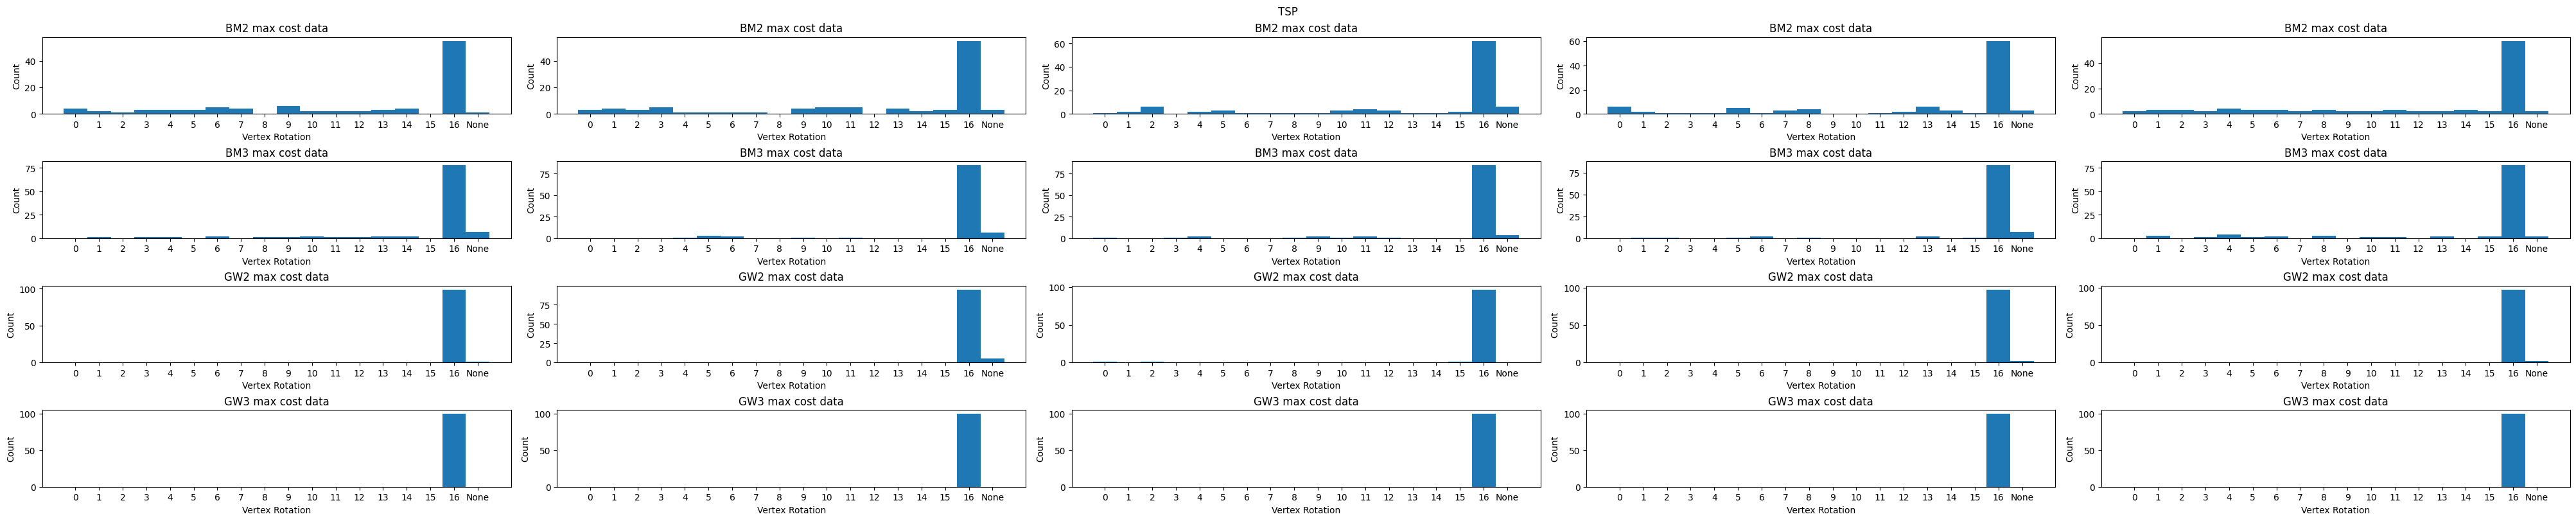

In [11]:
max_cost_hist("TSP",p_data)

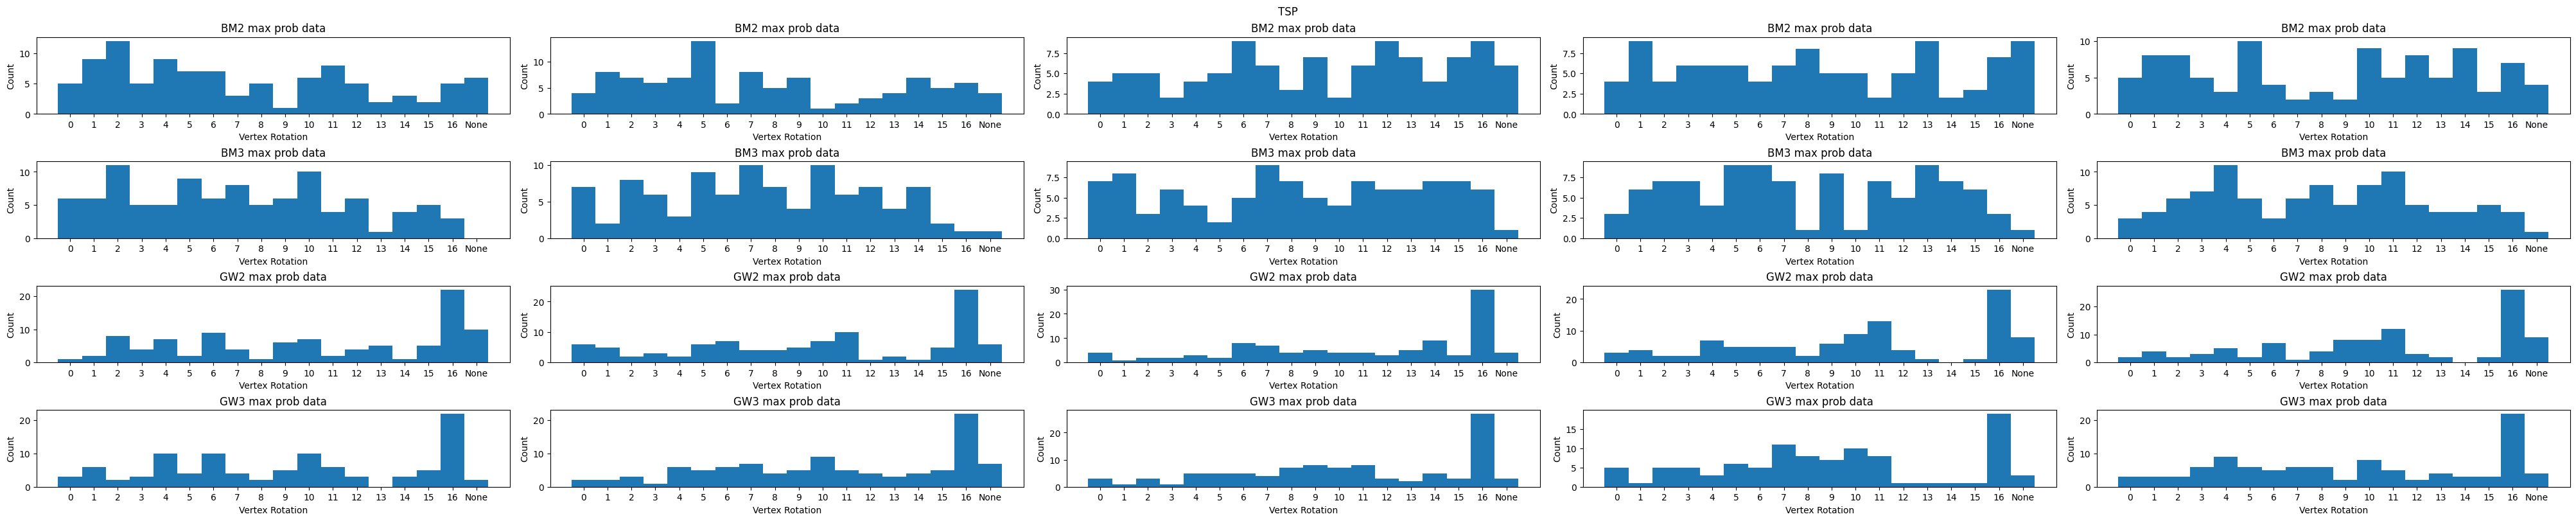

In [12]:
max_prob_hist("TSP",p_data)

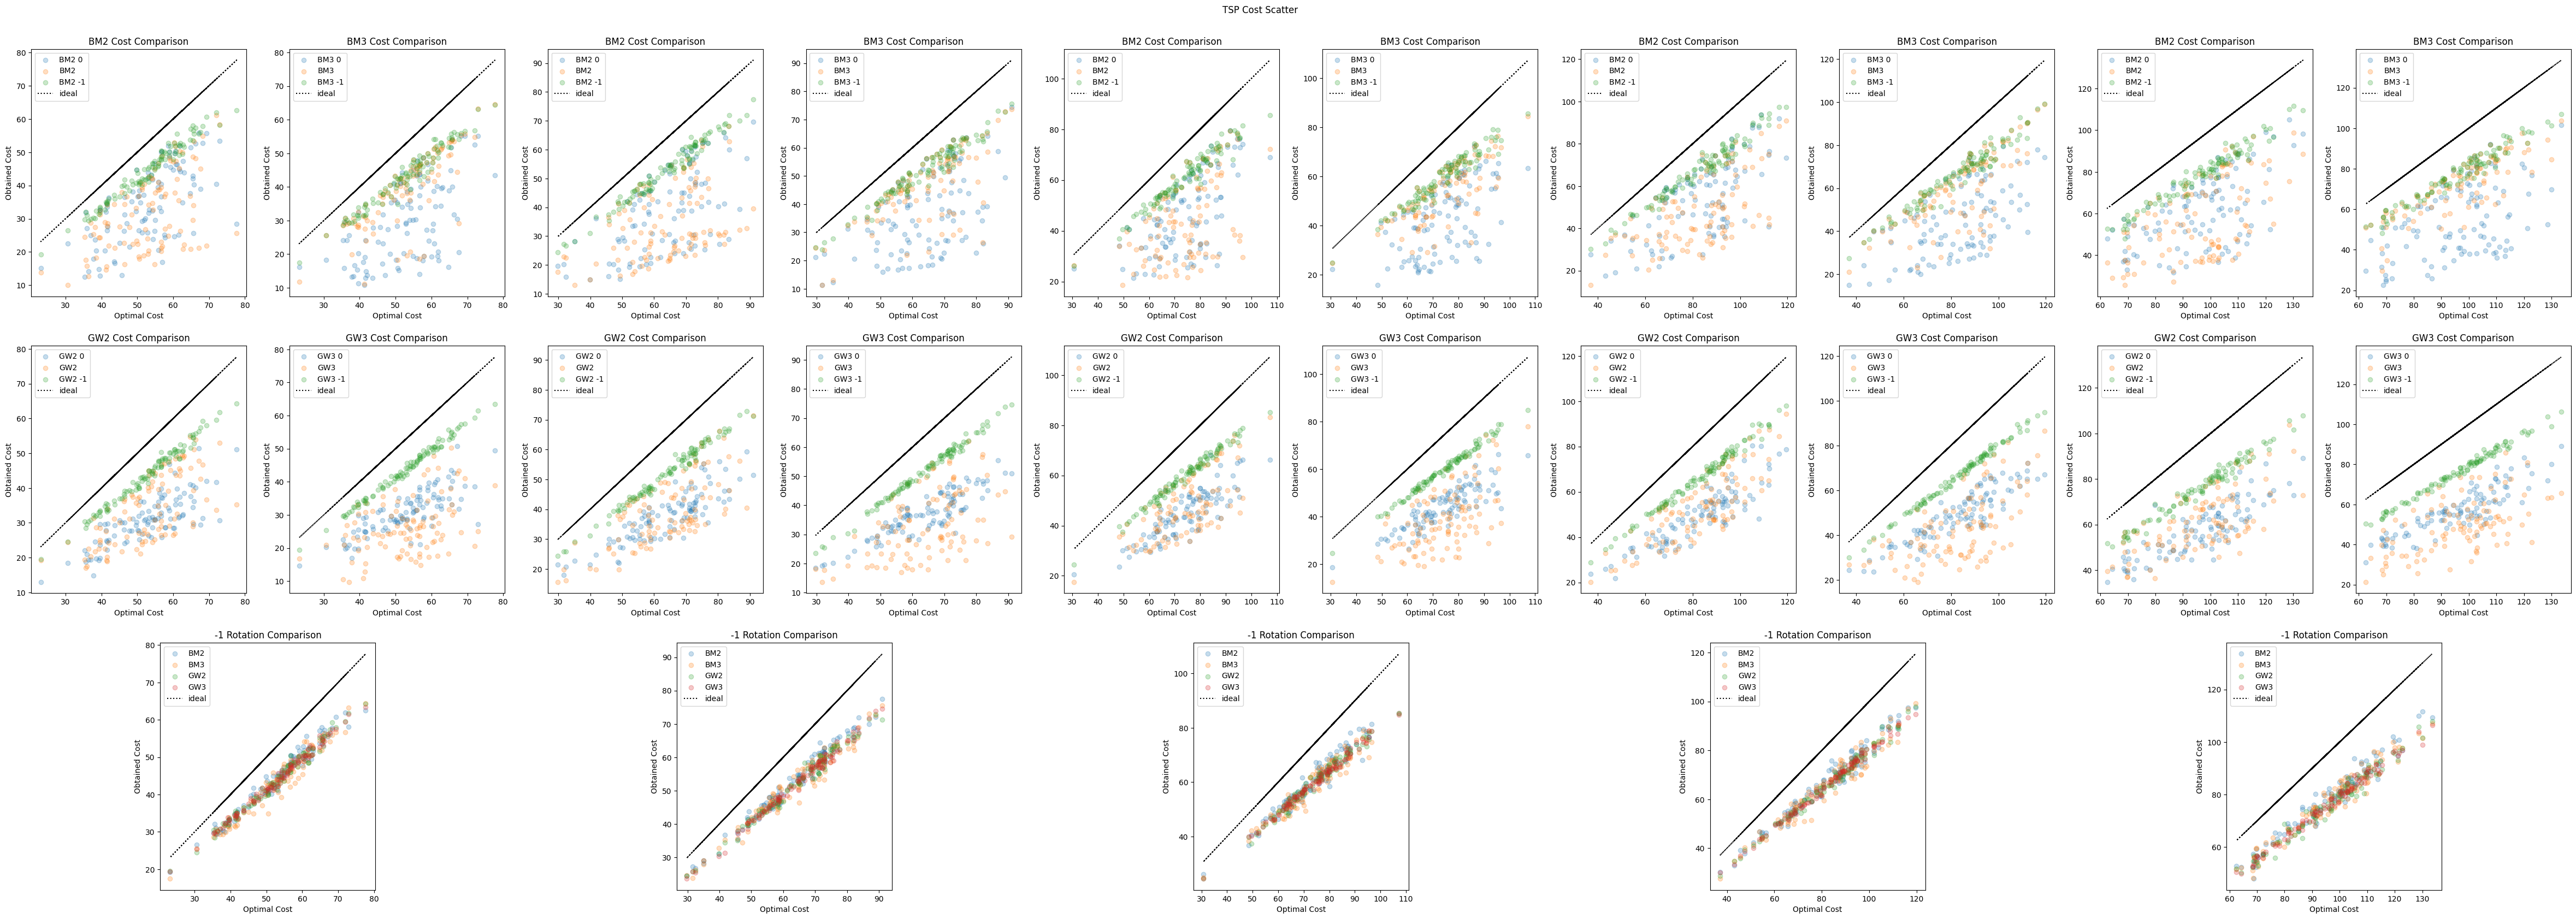

In [13]:
cost_scatter("TSP",p_data)

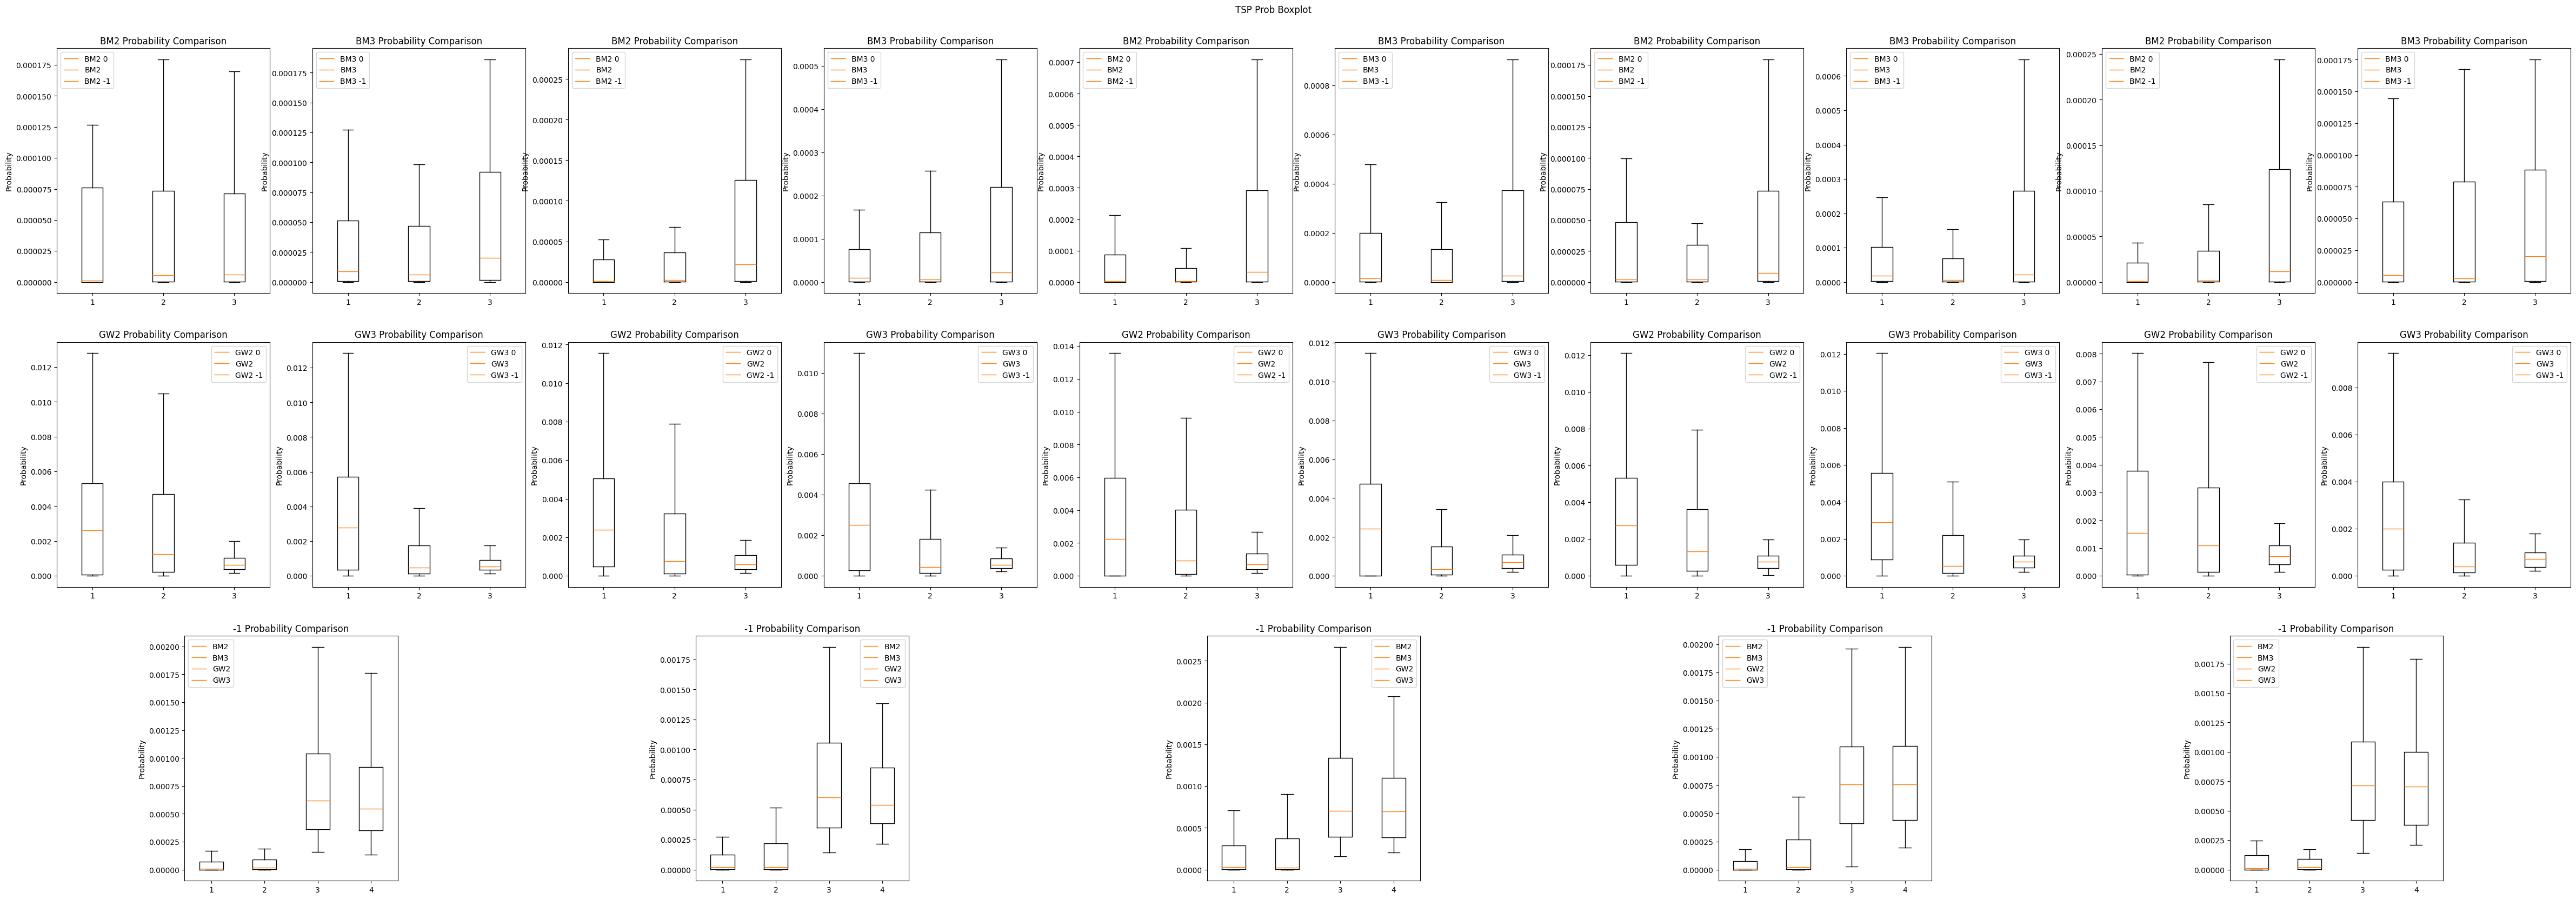

In [14]:
prob_boxplot("TSP",p_data)

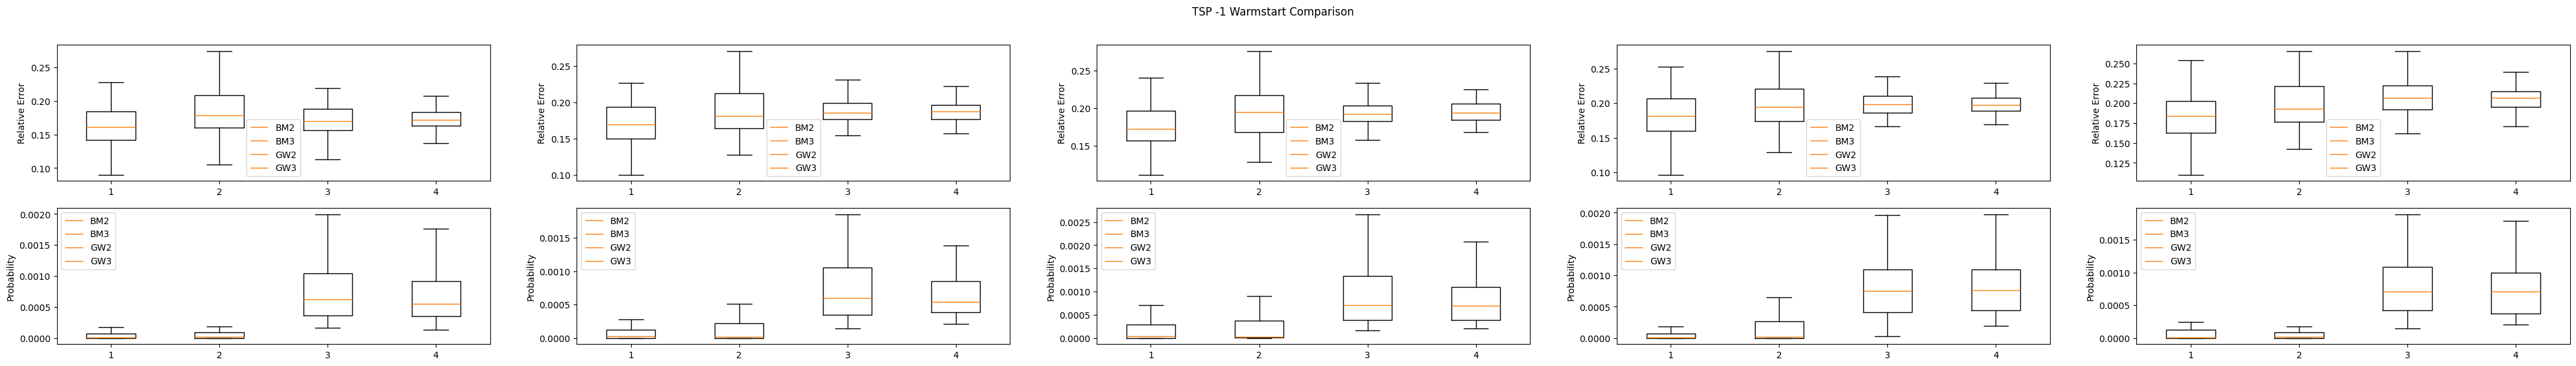

In [15]:
final_boxplot("TSP",p_data)

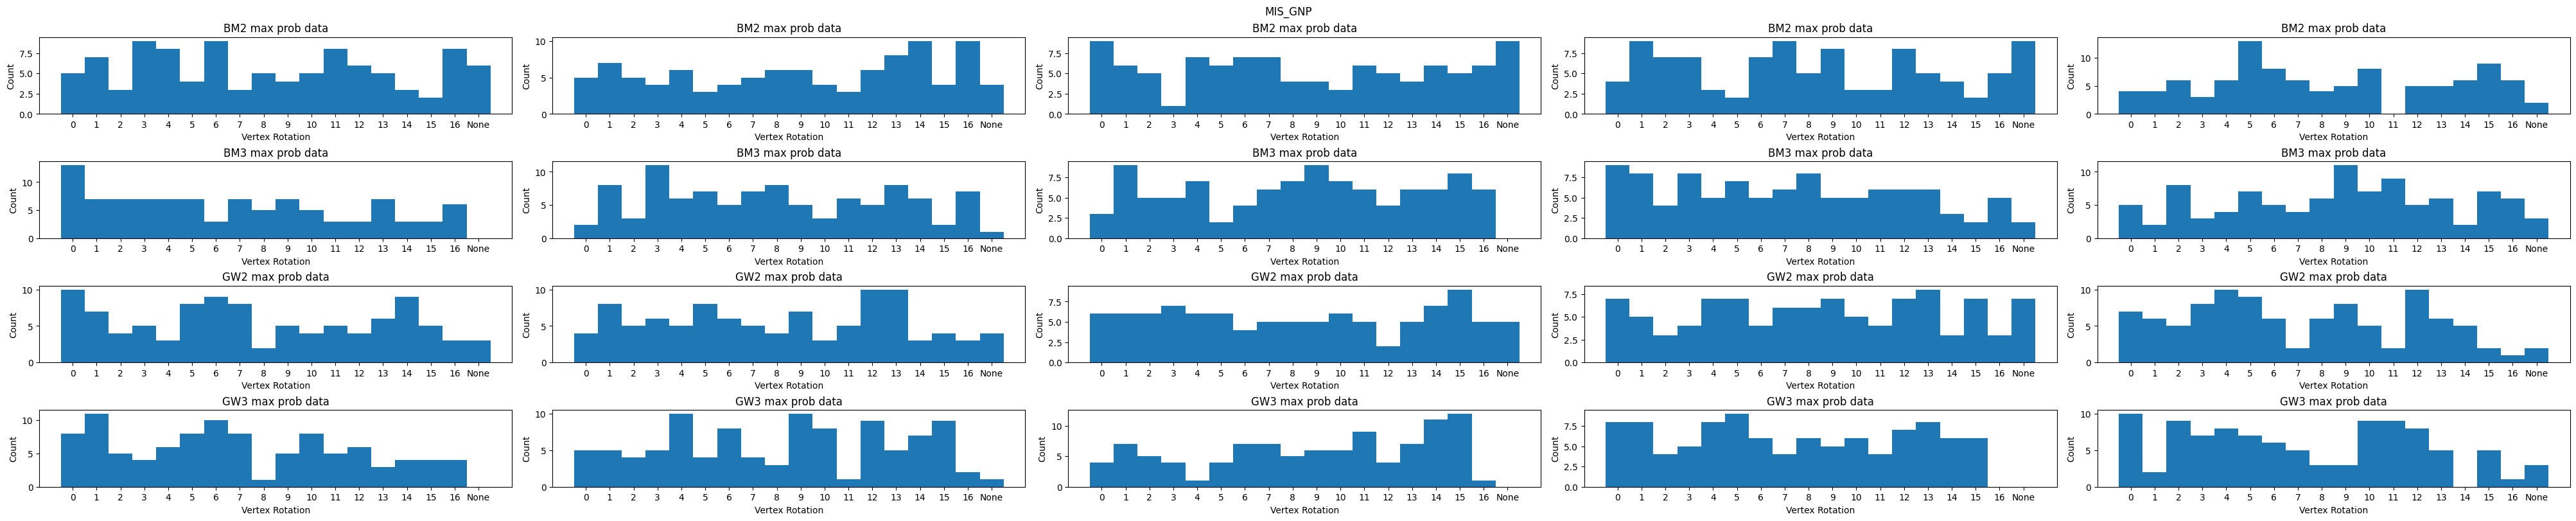

In [16]:
max_prob_hist("MIS_GNP",p_data)

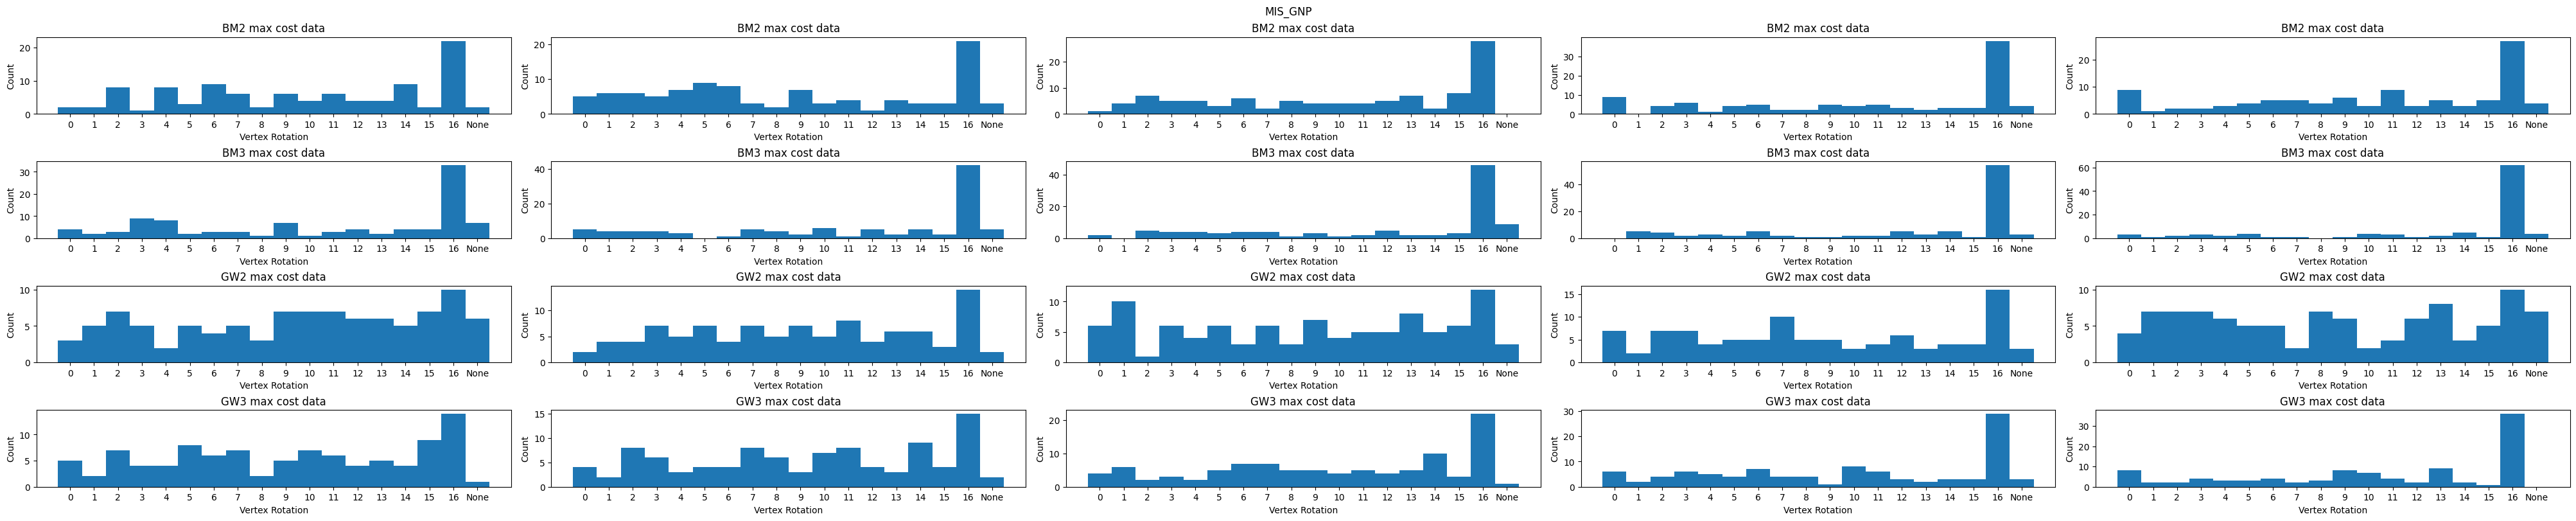

In [17]:
max_cost_hist("MIS_GNP",p_data)

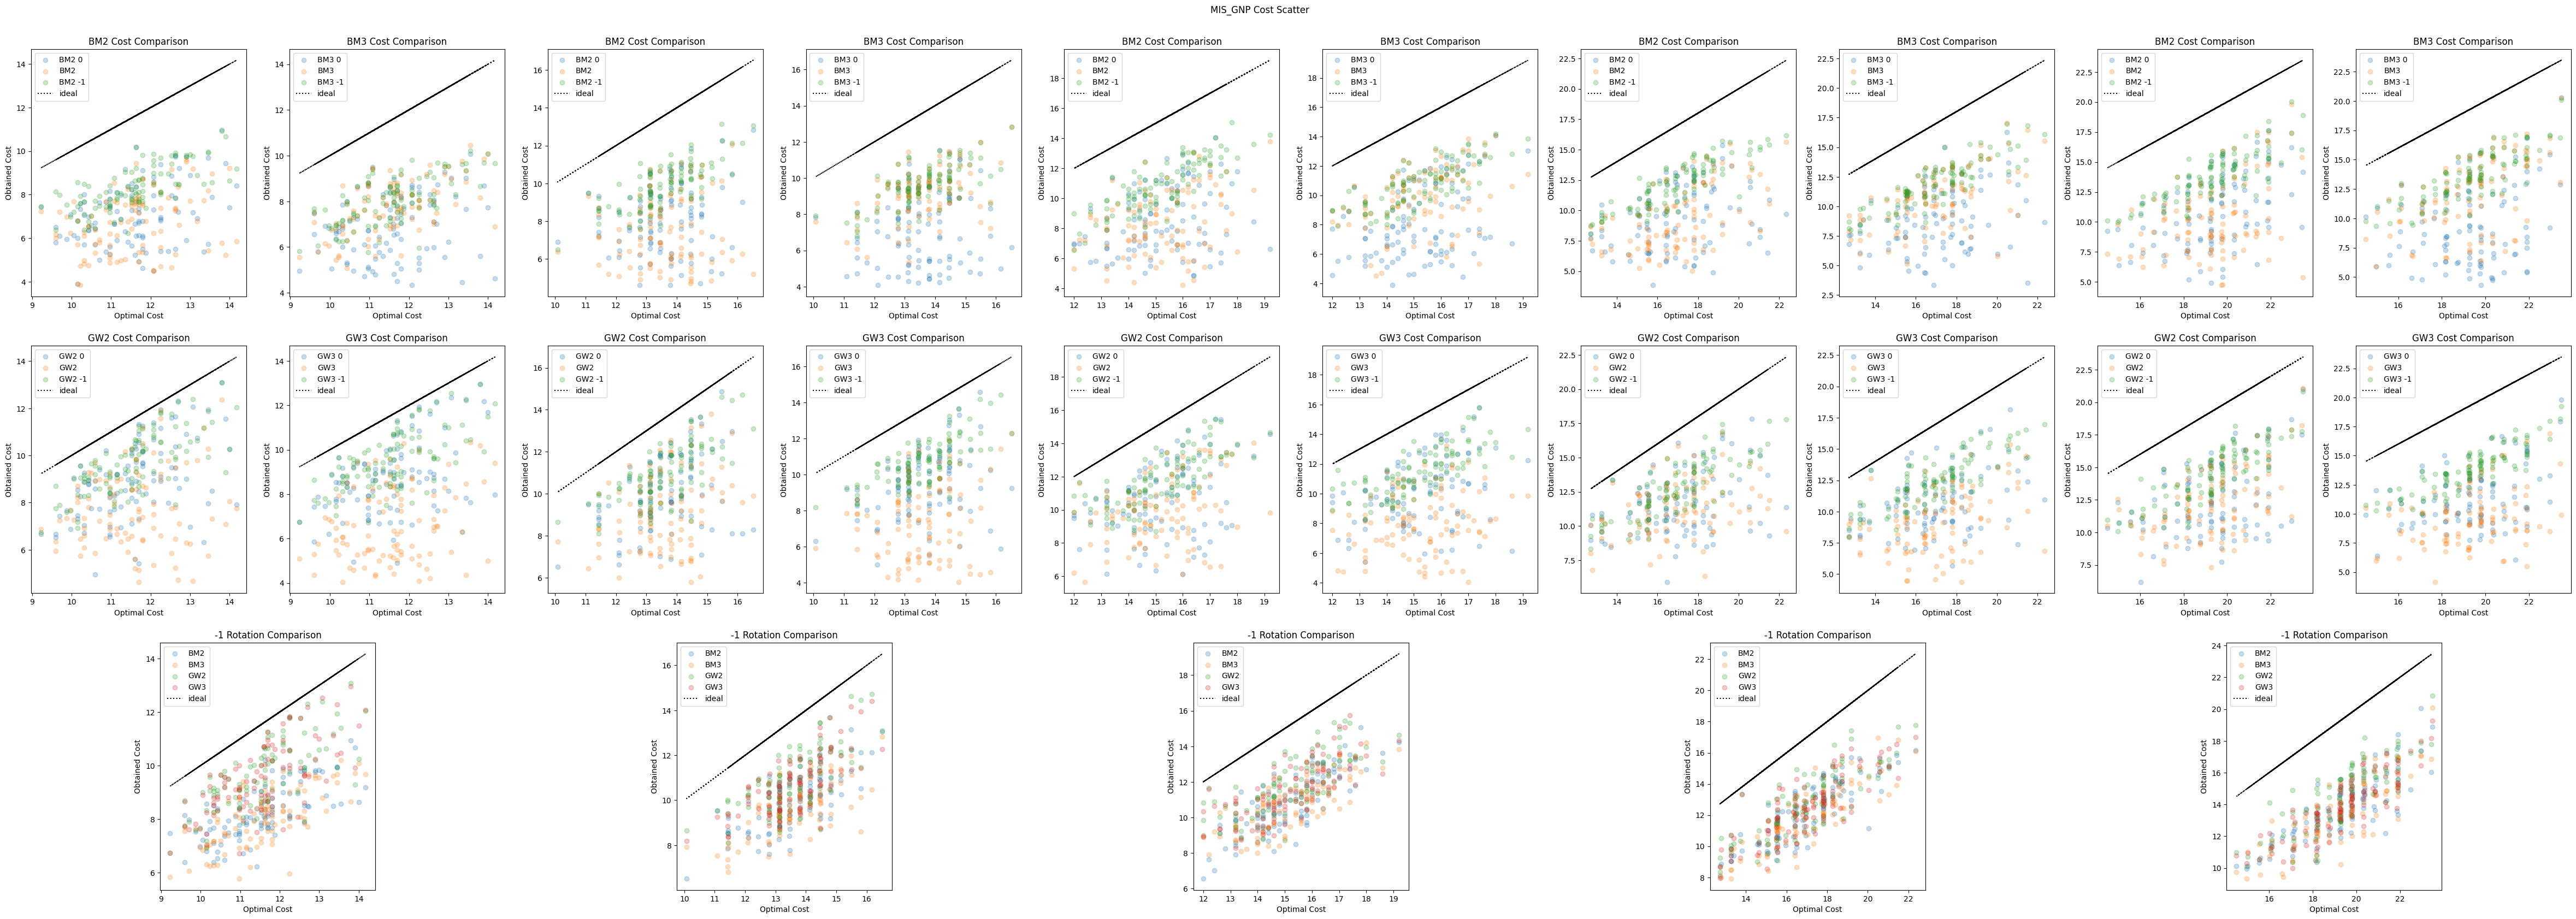

In [18]:
cost_scatter("MIS_GNP",p_data)

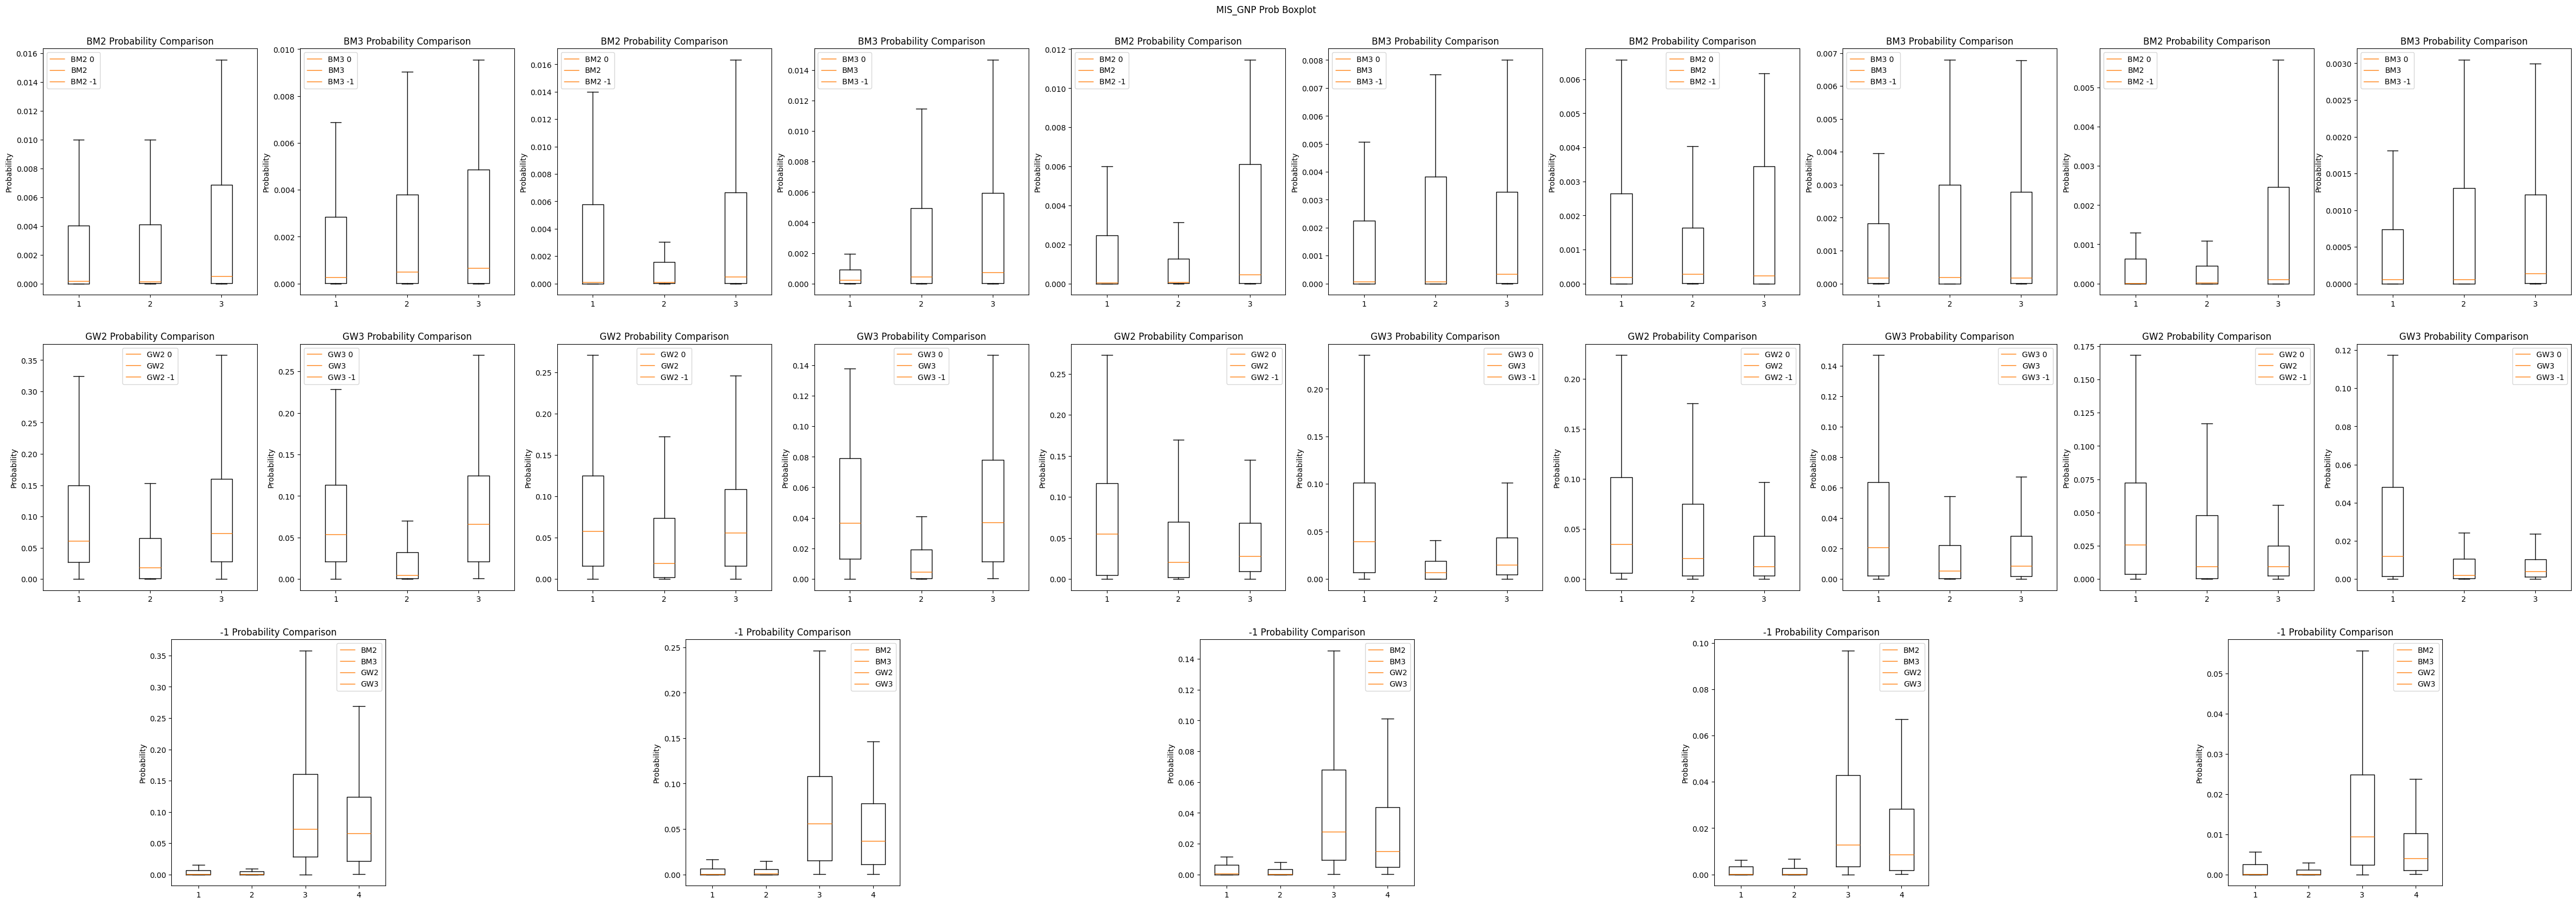

In [19]:
prob_boxplot("MIS_GNP",p_data)

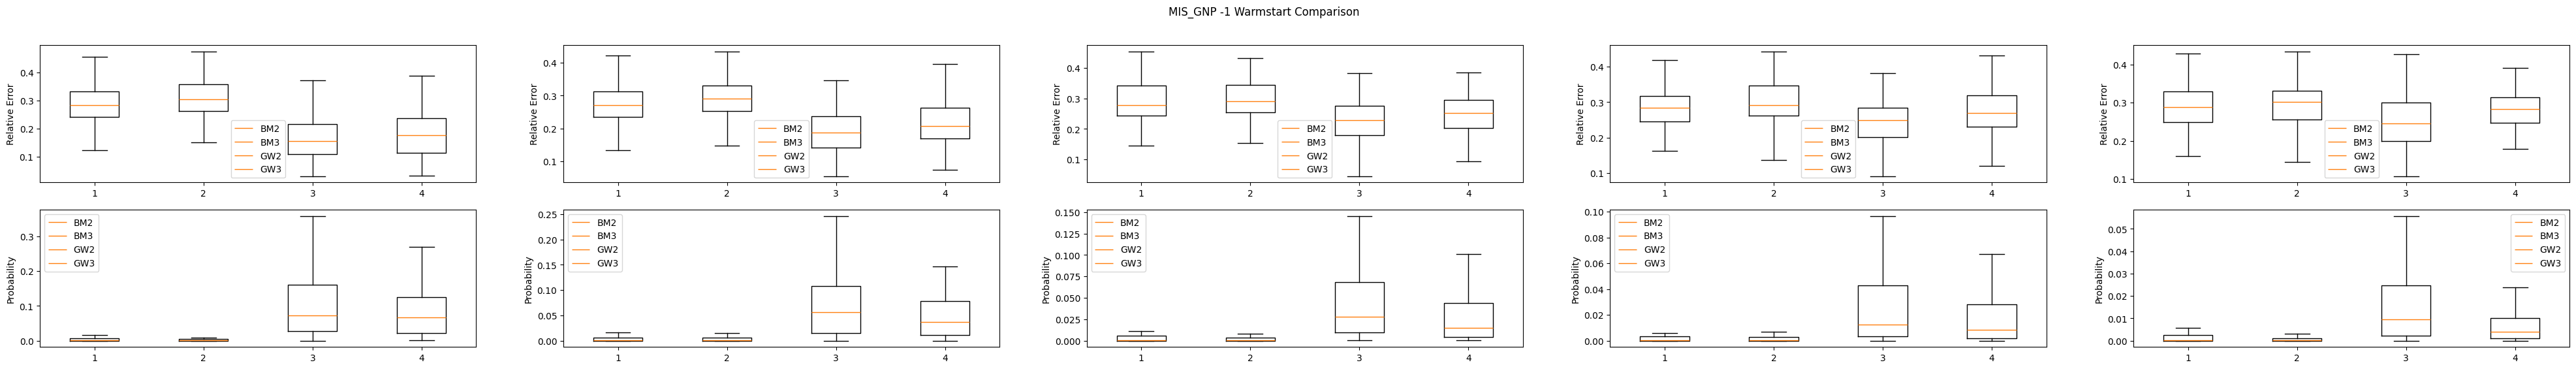

In [20]:
final_boxplot("MIS_GNP",p_data)

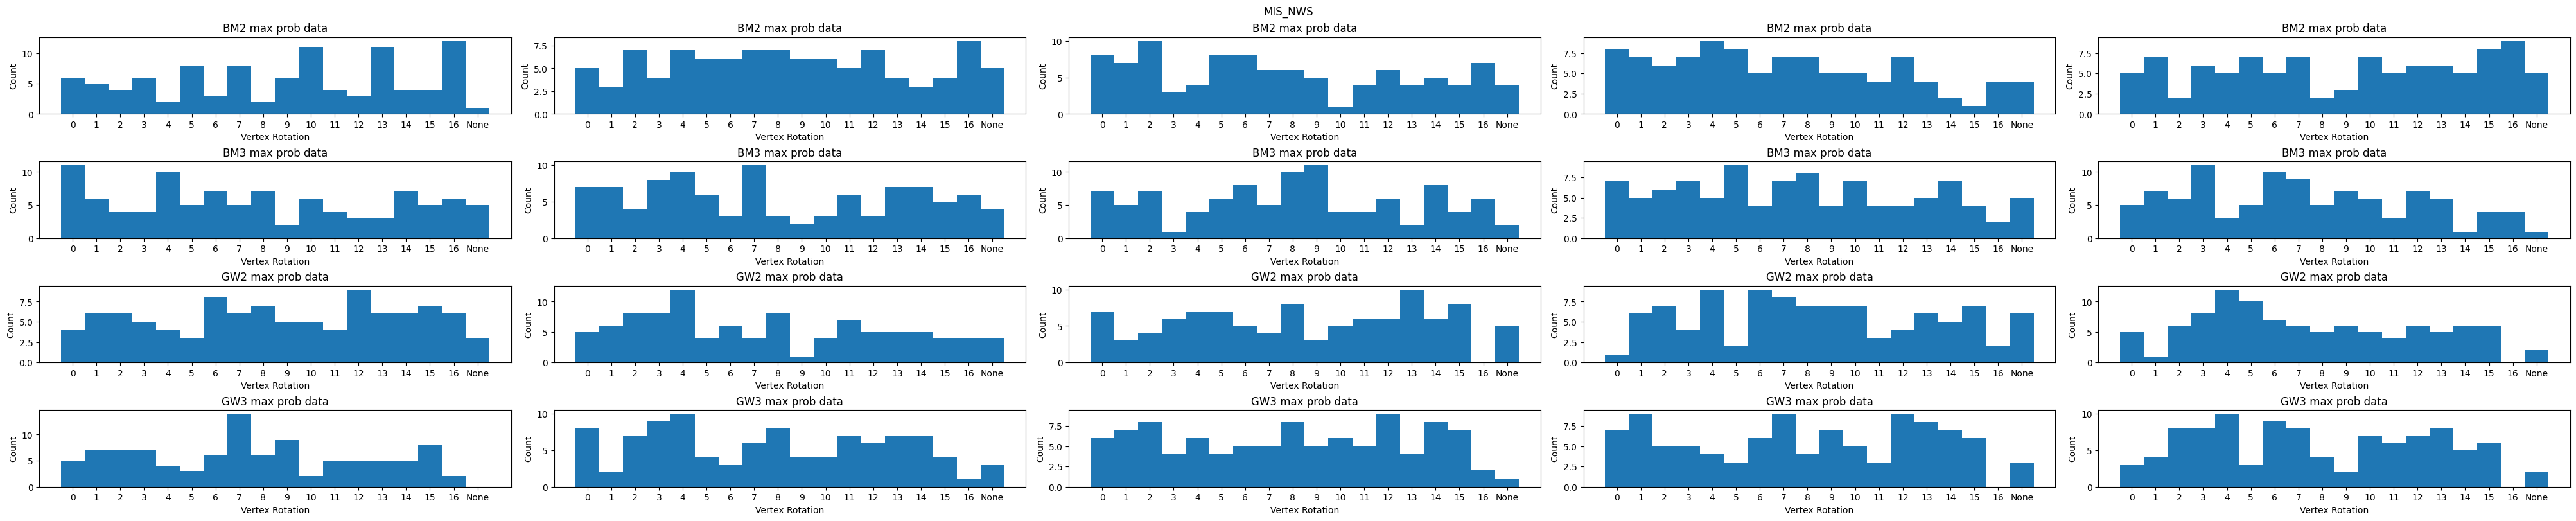

In [21]:
max_prob_hist("MIS_NWS",p_data)

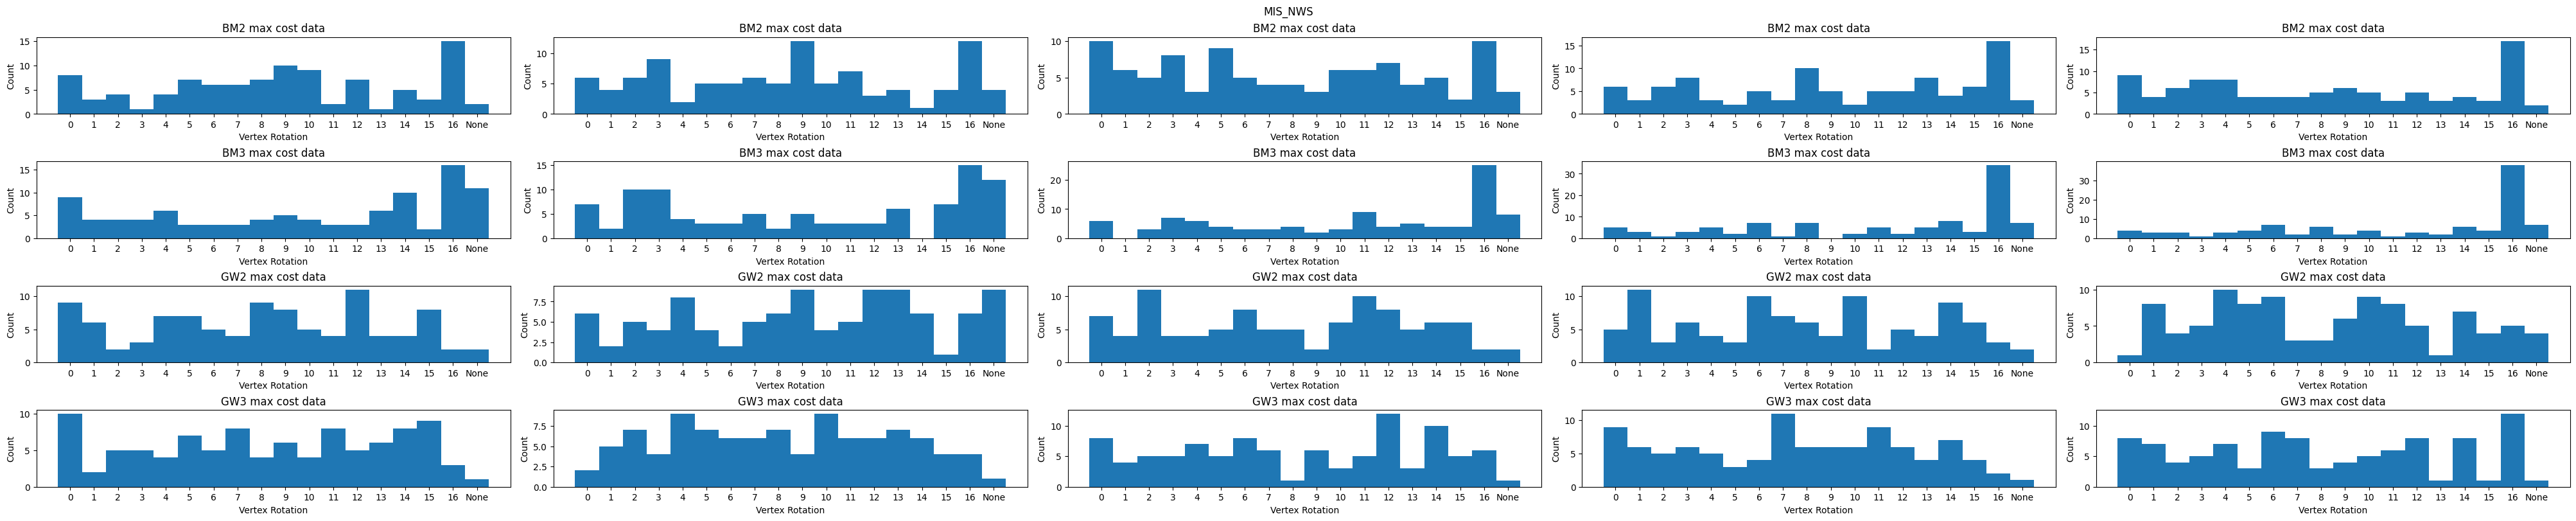

In [22]:
max_cost_hist("MIS_NWS",p_data)

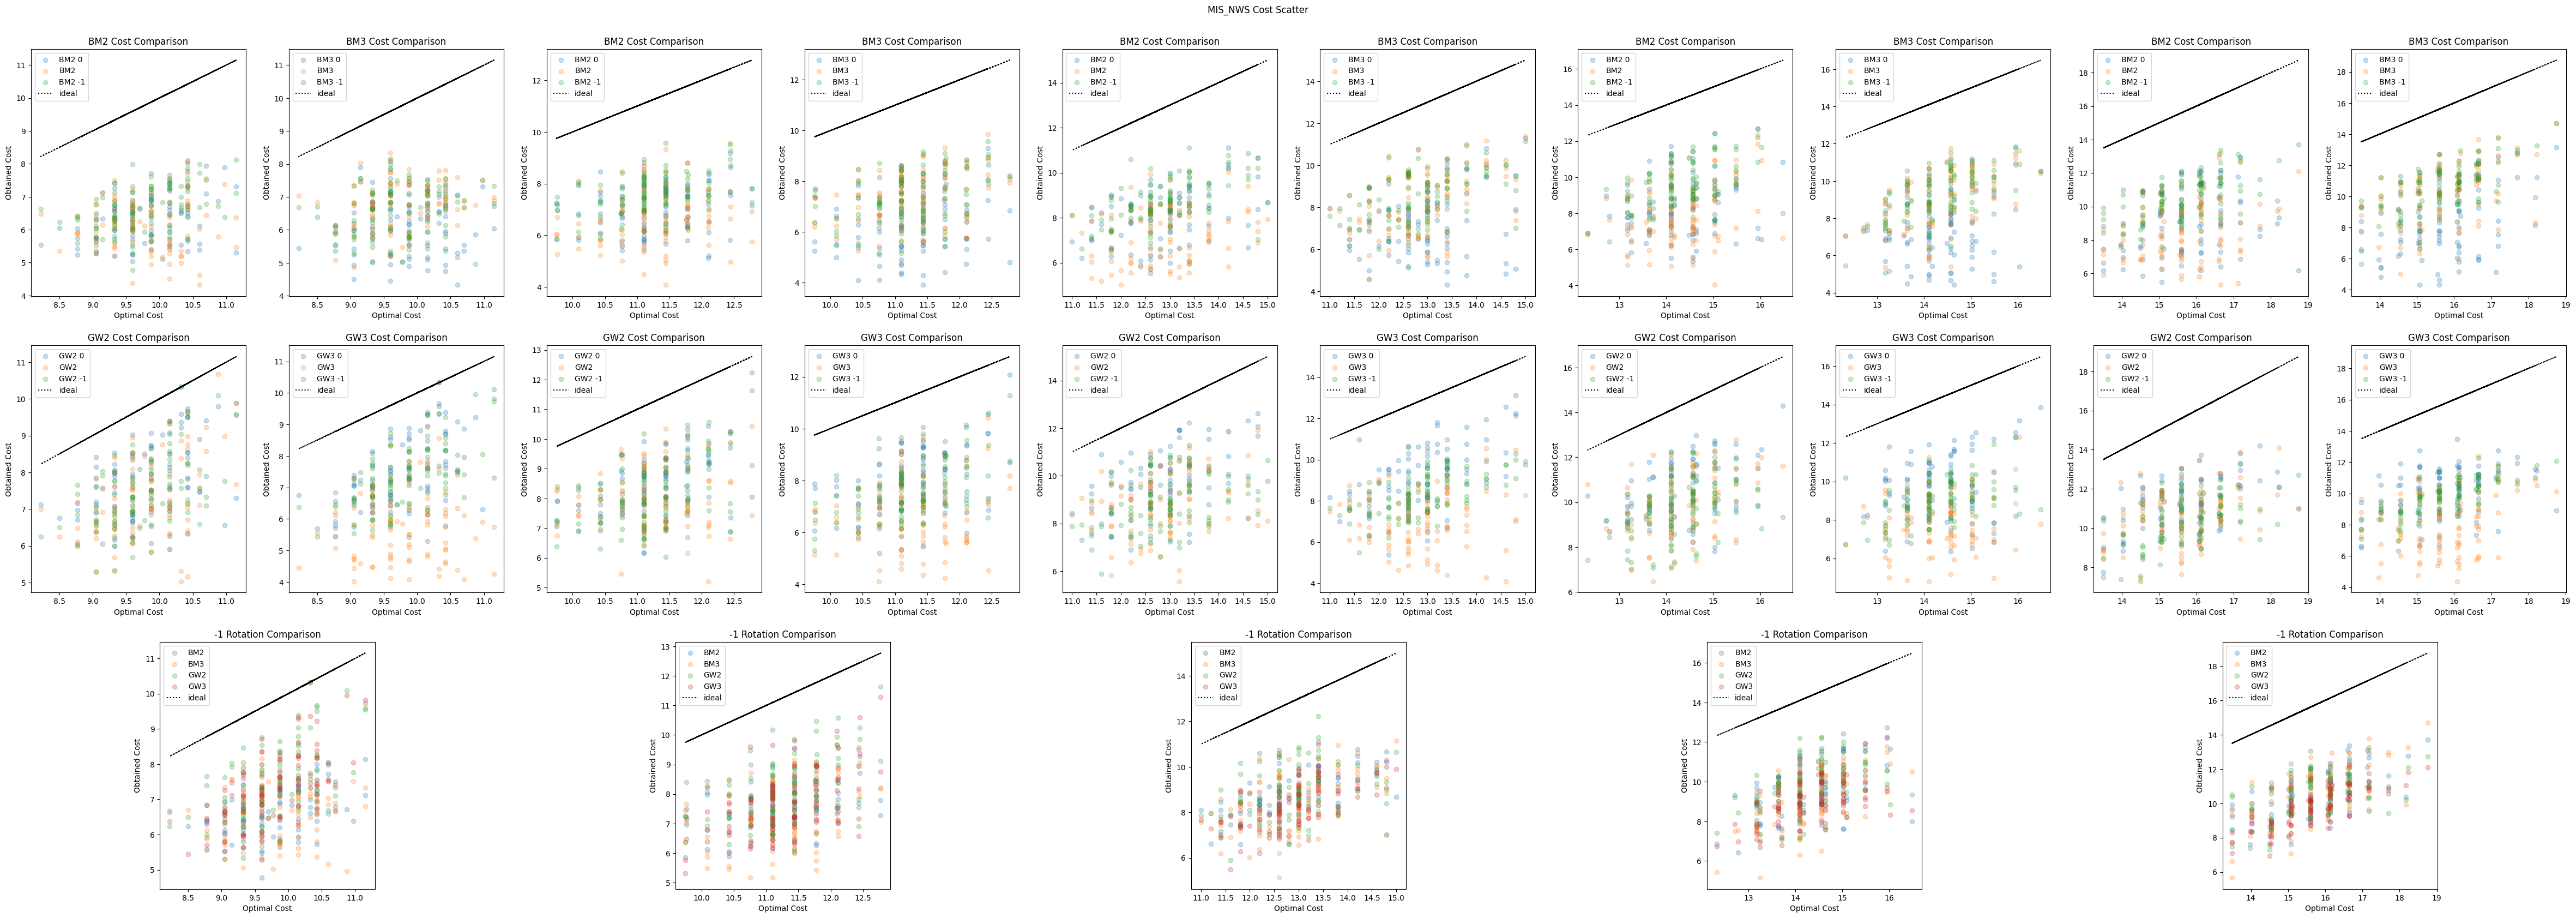

In [23]:
cost_scatter("MIS_NWS",p_data)

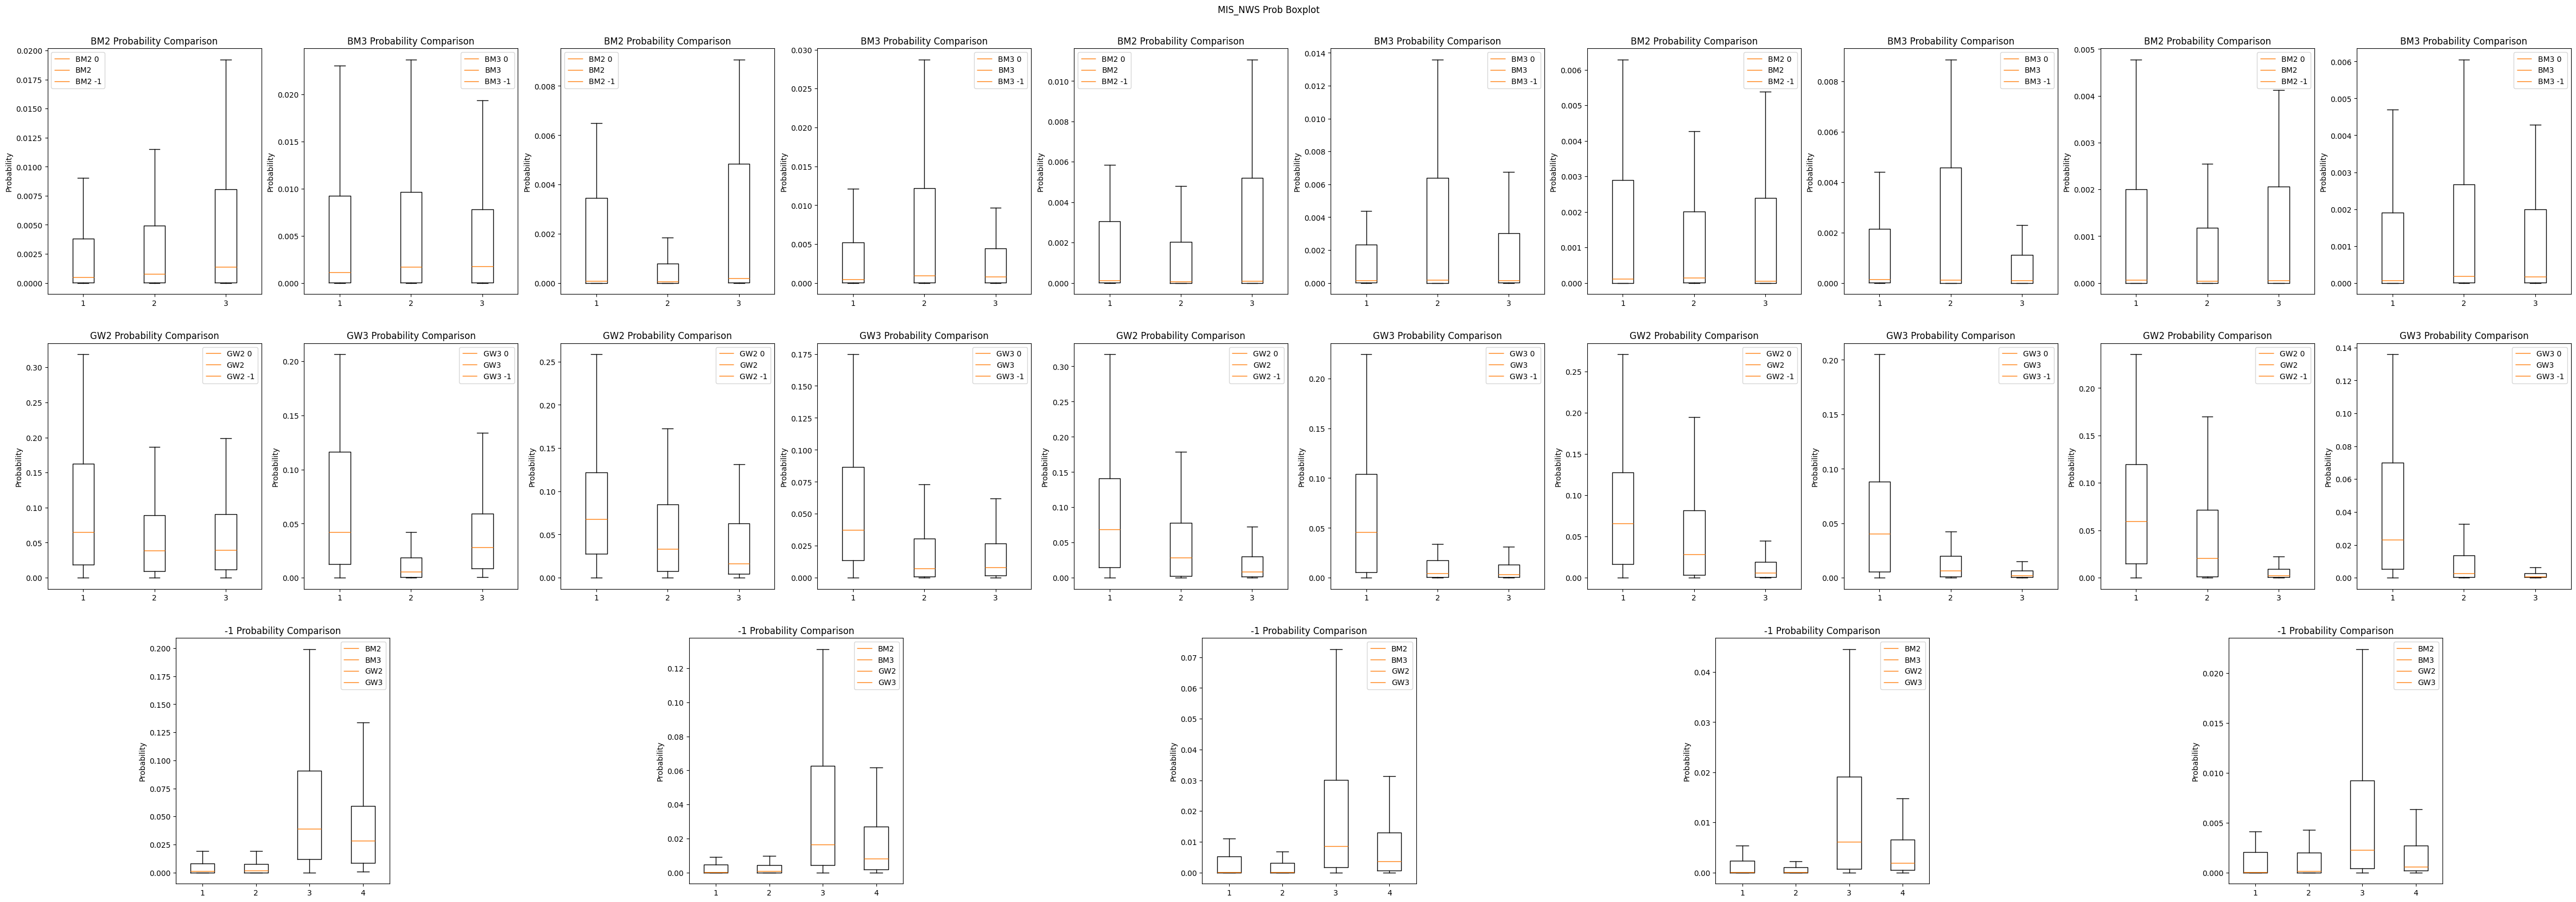

In [24]:
prob_boxplot("MIS_NWS",p_data)

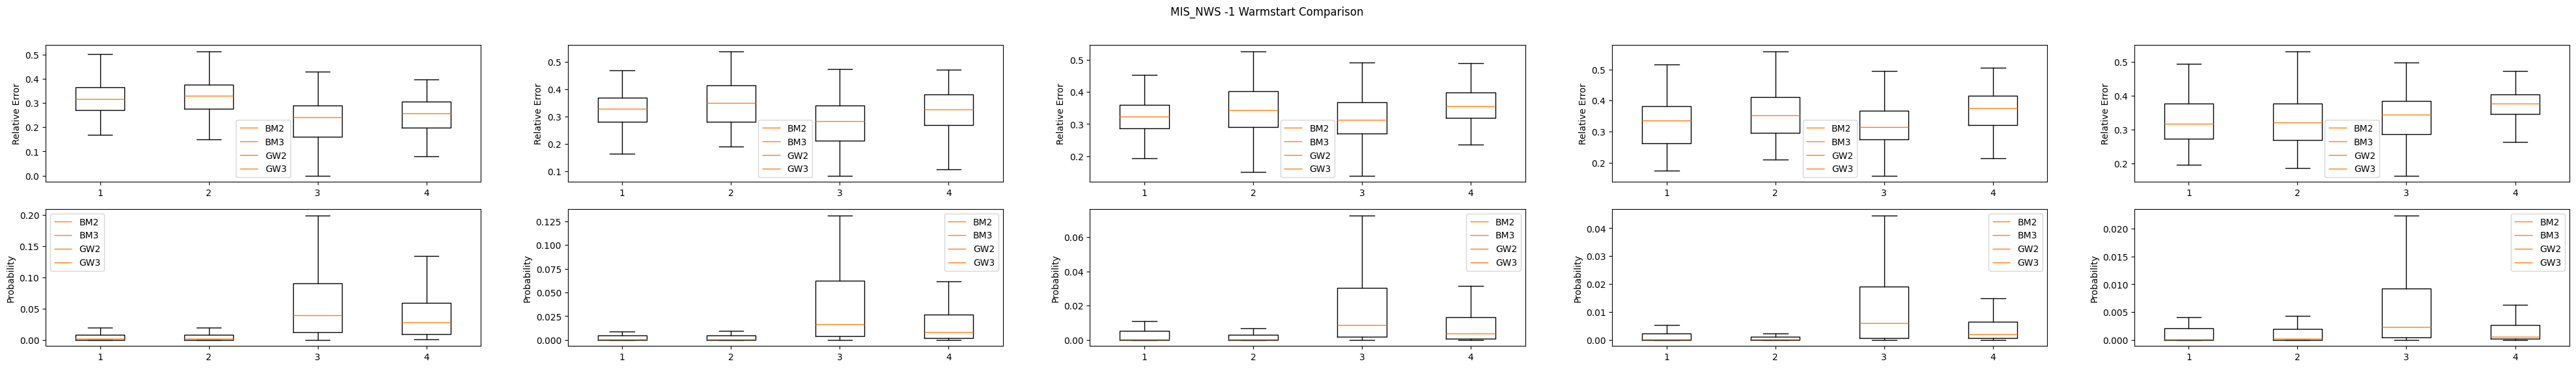

In [25]:
final_boxplot("MIS_NWS",p_data)